In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.decomposition import PCA
import seaborn as sns; sns.set()
from IPython.display import display

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


from scipy.signal import resample
from scipy import stats
import glob
import sys
import joblib
sys.path.insert(-1,'../Tools')
from data_analysis import df_vcg_vector
from data_parser_new import parse
from data_modification import trim_tat_patient, resample_patient

# Load data

In [2]:
#Load VCG atlas
atlas_file = '../Figure2/VCG_atlas_all.pickle'
pca = joblib.load(atlas_file)

weights_file = '../Figure2/VCG_atlas_all_weights.pickle'
X_weights = joblib.load(weights_file)

In [ ]:
#Load patient data
pt_files = glob.glob('../Data/BiV*/BiV*-LBBB_kVCG_model-out.txt')
pt_files.sort()
print(pt_files)
pt_VCGs = [pd.read_csv(f, header = None, names=['VCGx','VCGy','VCGz'], sep=' ', index_col=False) for f in pt_files] 

In [ ]:
df_VCG_mean = df_vcg_vector(pca.mean_)

## Resample the VCG

In [ ]:
pt_VCG_resamp = [np.nan]*len(pt_VCGs)

for i,df in enumerate(pt_VCGs):
    arr = resample(df.to_numpy(),100)
    pt_VCG_resamp[i] = pd.DataFrame(data = arr,columns = ['VCGx','VCGy','VCGz'])

## Resampled - normalized magnitude to atlas mean

In [26]:
mean_mag = max(np.linalg.norm(df_VCG_mean, axis=1))
print(mean_mag)
pt_VCGs_resamp_v_norm =[df/(max(np.linalg.norm(df, axis=1))/mean_mag) for df in pt_VCG_resamp]

6.656519101603906


In [28]:
pct_norm = pd.DataFrame()
for i,X in enumerate(pt_VCGs_resamp_v_norm):
    X_new = pd.concat([X['VCGx'],X['VCGy'],X['VCGz']],axis=0,ignore_index=True).to_numpy()
    w = pca.transform(X_new.reshape(1,-1))
    pct_out = np.zeros(len(w[0]))
    for j in range(len(w[0])):
        pct_out[j] = stats.percentileofscore(X_weights[:,j], w[0][j])
    pct_norm['BiV%s'%str(i+1)] = pct_out

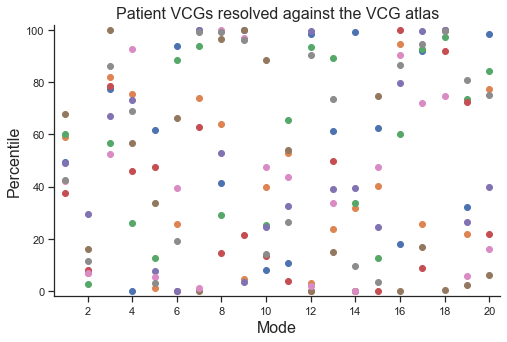

In [44]:
import seaborn as sns; sns.set_style("ticks")
#x_vals = np.zeros(8)
x_vals = np.arange(20)+1
pct_norm_arr = pct_norm.to_numpy()

fig_s, ax_s = plt.subplots(figsize = (8,5))

for z in range(8):
    #x_vals = np.zeros(8)+1+z
    plt.scatter(x_vals, pct_norm_arr[:,z])

ax_s.set_xlim([0.5, 20.5])
ax_s.set_ylim([-2, 102])
ax_s.set_xlabel('Mode',fontsize=16)
ax_s.set_ylabel('Percentile',fontsize=16)
ax_s.xaxis.set_major_locator(MaxNLocator(integer=True))
#ax_s.set_title('Patient VCG Mode Scores - VCG Resampled & Mag=Atlas Mean',fontsize=16)
ax_s.set_title('Patient VCGs resolved against the VCG atlas',fontsize=16)
sns.despine()
#plt.show()
plt.savefig('FigS1.pdf', transparent=True)